In [249]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [250]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [251]:
from torchvision.models import vgg19
from torchsummary import summary

vgg = vgg19(pretrained=True).to(device)
summary(vgg, (3, 224, 224))
print(vgg.features)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

torch.Size([1, 3, 512, 755])


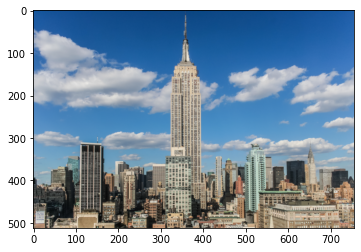

In [252]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    #transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()
])

def img_loader(img_path, size=None):
    img = Image.open(img_path)
    if size is not None:
        img = transforms.functional.resize(img=img, size=size)
    w, h = img.size
    if max(h, w) > imsize:
        img = transforms.functional.resize(img, size=imsize)
    # fake batch dimension required to fit network's input dimensions
    img = loader(img).unsqueeze(0)
    return img.to(device, torch.float)


unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    img = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    img = img.squeeze(0)      # remove the fake batch dimension
    img = unloader(img)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

img = img_loader('content/empire_state_bulding.jpg')
print(img.shape)

imshow(img)

In [253]:
class ContentLoss(nn.Module):
    
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = None
    
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [254]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = None

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    

In [255]:
class TotalVariationLoss(nn.Module):
    
    def __init__(self,TVLoss_weight=1):
        super(TotalVariationLoss,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h =  (x.size()[2]-1) * x.size()[3]
        count_w = x.size()[2] * (x.size()[3] - 1)
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size

In [256]:
# PyTorch’s implementation of VGG is a module divided into two child Sequential modules:
#   1. features (containing convolution and pooling layers)
#   2. classifier (containing fully connected layers)
# use the features module because we need the output of the individual convolution layers to measure content and style loss
# Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval()
vgg = models.vgg19(pretrained=True).features.to(device).eval()

summary(vgg, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

In [257]:
# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [258]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [259]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()
# VGG net are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
# We will use them to normalize the image before sending it into the network.
vgg_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
vgg_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

content_path = 'content/brooklyn_bridge.jpg'
style_path = 'style/udnie.jpg'

content_img = img_loader(content_path)
_, _, h, w = content_img.shape
style_img = img_loader(style_path, size=(h, w))

model, _, _ = get_style_model_and_losses(
    vgg, vgg_normalization_mean, vgg_normalization_std,
    style_img, content_img,
    content_layers=content_layers_default,
    style_layers=style_layers_default
)

print(model)

Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


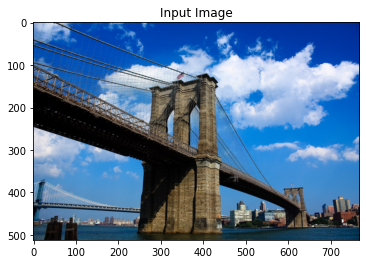

In [260]:
content_path = 'content/brooklyn_bridge.jpg'
style_path = 'style/monet_woman_with_a_parasol.jpg'

content_img = img_loader(content_path)
style_img = img_loader(style_path)

input_img = content_img.clone()
#input_img = torch.randn(content_img.data.size(), device=device)
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(content_img, title='Content Image')
plt.figure()
imshow(style_img, title='Style Image')
plt.figure()
imshow(input_img, title='Input Image')

In [261]:
def high_pass_x_y(img):
  x_var = img[:,:,:,1:] - img[:,:,:,:-1]
  y_var = img[:,:,1:,:] - img[:,:,:-1,:]
  return x_var, y_var

def total_variation_loss(img):
    x_deltas, y_deltas = high_pass_x_y(img)
    return torch.sum(torch.abs(x_deltas)) + torch.sum(torch.abs(y_deltas))

In [262]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [265]:
def style_transfer(content_path, style_path, num_steps=300, style_weight=1e6, content_weight=1, from_content=True):
    """Run the style transfer."""
    content_img = img_loader(content_path)
    _, _, h, w = content_img.shape
    style_img = img_loader(style_path, size=(h, w))
    if from_content:
        img = content_img.clone()
    else:
        img = torch.randn(content_img.data.size(), device=device)

    plt.figure()
    imshow(content_img, title='Content Image')
    plt.figure()
    imshow(style_img, title='Style Image')


    print('Building the style transfer model..')
    vgg = models.vgg19(pretrained=True).features.to(device).eval()
    # VGG net are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
    # We will use them to normalize the image before sending it into the network.
    vgg_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    vgg_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    model, style_losses, content_losses = get_style_model_and_losses(vgg,
        vgg_normalization_mean, vgg_normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(img)

    
    #summary(model, input_size=(3, h, w))

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            TV_loss = total_variation_loss(img)
            total_variation_score = 1e-5 * TV_loss

            loss = style_score + content_score + total_variation_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f} Total Variation Loss: {:4f}'.format(
                    style_score.item(), content_score.item(), TV_loss))
                print()

            return style_score + content_score

        optimizer.step(closure)
        
        '''
        if run[0] % 50 == 0:
            tmp = img.clone()
            tmp.data.clamp_(0, 1)
            plt.figure()
            imshow(tmp, title='step: {step:d}'.format(step=run[0]))
        '''

    # a last correction...
    img.data.clamp_(0, 1)

    return img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 13.072919 Content Loss: 15.009176 Total Variation Loss: 60868.980469

run [100]:
Style Loss : 4.757421 Content Loss: 10.323423 Total Variation Loss: 59663.601562

run [150]:
Style Loss : 2.160587 Content Loss: 8.364056 Total Variation Loss: 59027.101562

run [200]:
Style Loss : 1.152943 Content Loss: 7.483638 Total Variation Loss: 57650.441406

run [250]:
Style Loss : 0.750371 Content Loss: 6.956679 Total Variation Loss: 55344.726562

run [300]:
Style Loss : 0.576217 Content Loss: 6.652368 Total Variation Loss: 53072.953125



/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


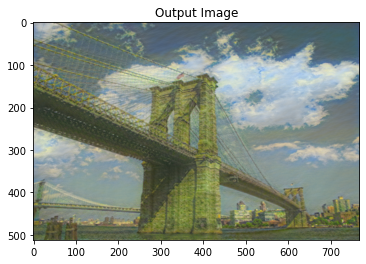

In [266]:
output = style_transfer(content_path, style_path)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()